# MLP, GBR, LR on MCR & MT Data

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
file = r'/content/drive/MyDrive/Colab/mlp-mcr/dataset.csv'

Data

In [24]:
import pandas as pd
import numpy as np

df = pd.read_csv(file)

# dataset
dataset = df.values
X = dataset[:, 6] # mt column
print(np.min(X)," ",np.max(X))
print(len(X))
Y = dataset[:, 5] # mcr column
print(np.min(Y)," ",np.max(Y))
print(len(Y))

0.01   5858.833333333333
179996
0.0253444780071999   4874.2
179996


Reshape + Split

In [25]:
X = X.reshape(-1, 1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print(len(X_train), len(Y_train))

115196 115196


LR

In [26]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(X_train, Y_train)
Y_predict_lr = lr.predict(X_test)

GBR

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(subsample=0.8,
                                learning_rate=0.4,
                                n_estimators=15,
                                max_depth=8,
                                min_samples_split=200,
                                min_samples_leaf=40,
                                loss="absolute_error")
gbr.fit(X_train, Y_train)
Y_predict_gbr = gbr.predict(X_test)

MLP

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 2),
            nn.Linear(2, 1)
        )

    def forward(self, x):
        return self.layers(x)

mlp = MLP()

optimizer = optim.Adam(mlp.parameters(), lr=0.003)

criterion = nn.L1Loss()

X_train = torch.tensor(X_train.astype(np.float32))
Y_train = torch.tensor(Y_train.astype(np.float32))
X_val = torch.tensor(X_val.astype(np.float32))
Y_val = torch.tensor(Y_val.astype(np.float32))
X_test = torch.tensor(X_test.astype(np.float32))
Y_test = torch.tensor(Y_test.astype(np.float32))

from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=64)
epochs = 3
losses = []

for epoch in range(epochs):
    mlp.train()
    epoch_loss = 0

    for input_data, target_data in train_loader:

        optimizer.zero_grad()
        # fp
        output = mlp(input_data)
        # loss
        loss = criterion(output, target_data.view(-1, 1))
        epoch_loss += loss.item()
        # bp
        loss.backward()
        # update
        optimizer.step()

    # avg loss
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    # print
    if epoch % 1 == 0:
        print("Epoch [{}/{}], Loss: {:.4f}".format(epoch, epochs, avg_loss))
mlp.eval()
with torch.no_grad():
    Y_predict_mlp = mlp(X_test)
    Y_predict_mlp = Y_predict_mlp.numpy()

Epoch [0/3], Loss: 12.6664
Epoch [1/3], Loss: 9.6078
Epoch [2/3], Loss: 9.6073


Graph

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

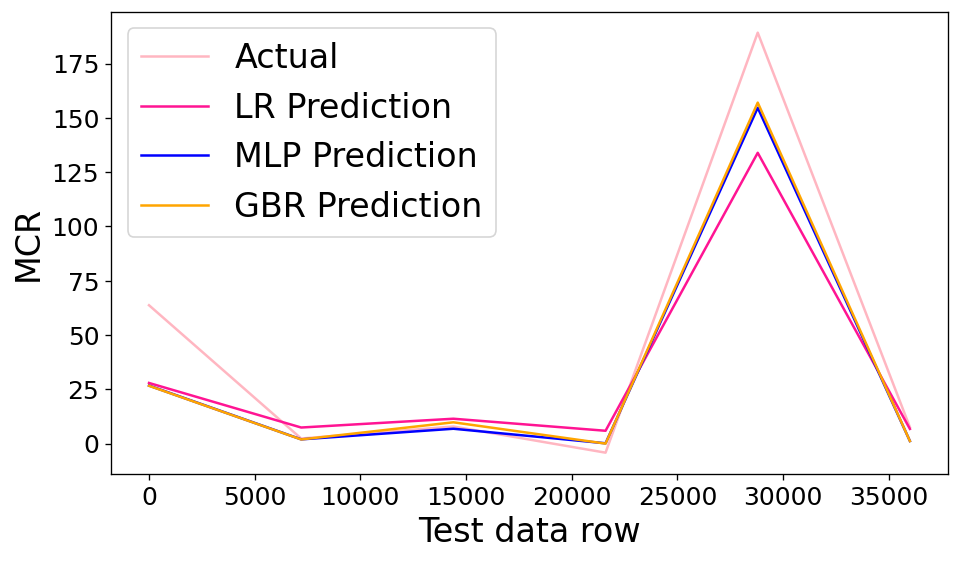

In [29]:
from google.colab import files
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

plt.figure(figsize=(9, 5), dpi=120)
X_Y_Spline = make_interp_spline(np.arange(36000), Y_test)
"""returns evenly spaced numbers
   over a specified interval."""
X_ = np.linspace(np.arange(36000).min(), np.arange(36000).max(), 6)
Y_ = X_Y_Spline(X_)

plt.plot(X_,Y_, label='Actual', color="lightpink")
X_Y_Spline = make_interp_spline(np.arange(36000), Y_predict_lr)
Y_ = X_Y_Spline(X_)

plt.plot(X_,Y_, label='LR Prediction', color="deeppink")
X_Y_Spline = make_interp_spline(np.arange(36000), Y_predict_mlp)
Y_ = X_Y_Spline(X_)

plt.plot(X_,Y_,  label='MLP Prediction', color="blue")
X_Y_Spline = make_interp_spline(np.arange(36000), Y_predict_gbr)
Y_ = X_Y_Spline(X_)
plt.subplot().tick_params(labelsize=15)
plt.plot(X_,Y_,  label='GBR Prediction', color="orange")
plt.ylabel('MCR', fontsize=20)
plt.xlabel('Test data row', fontsize=20)
plt.legend( fontsize=20)
plt.savefig("comparison.pdf", format="pdf", bbox_inches="tight")
files.download("comparison.pdf")